In [2]:
#import libraries
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [3]:
#access data

data= pd.read_csv('bills.csv')
text = pd.read_csv('billtext.csv', sep='\t')

/Users/Jade/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (11,13,30,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data cleaning

Before performing the NLP analyses, datasets need to undergo the following cleaning:
- Datasets need to be merged
- Columns not used in analyses removed
- Columns for analyses created

In [4]:
#Concatenate the two datasets.  
bills = pd.concat([data, text['bill_text_clean']], axis=1)

In [5]:
#Observing characteristics of the dataframe
bills.shape

(28160, 60)

In [6]:
bills.head()

,id,BillID,BillNum,BillType,ByReq,Chamber,Commem,Cong,Cosponsr,IntrDate,...,NameLast,Party,PooleID,Postal,State,ChRef,RankRef,SubChRef,SubRankRef,bill_text_clean
0,310987,106-S-1,1,S,0.0,1,0,106,10.0,12/15/00,...,McConnell,200.0,14921,KY,51,0.0,0.0,0.0,0.0,[Congressional Bills 106th Congress]\r\n[From ...
1,310058,106-S-2,2,S,0.0,1,0,106,6.0,1/19/99,...,Jeffords,328.0,14240,VT,6,0.0,0.0,0.0,0.0,[Congressional Bills 106th Congress]\r\n[From ...
2,311917,106-S-3,3,S,0.0,1,0,106,17.0,1/19/99,...,Grams,0.0,29367,MN,33,0.0,0.0,0.0,0.0,[Congressional Bills 106th Congress]\r\n[From ...
3,310526,106-S-4,4,S,0.0,1,0,106,31.0,1/19/99,...,Warner,200.0,14712,VA,40,0.0,0.0,0.0,0.0,[Congressional Bills 106th Congress]\r\n[From ...
4,311054,106-S-5,5,S,0.0,1,0,106,15.0,1/19/99,...,DeWine,200.0,15020,OH,24,0.0,0.0,0.0,0.0,[Congressional Bills 106th Congress]\r\n[From ...


In [7]:
#Removing lines where bill text is missing

data = bills[bills['bill_text_clean']!='Problem']

In [8]:
data.columns

Index([u'id', u'BillID', u'BillNum', u'BillType', u'ByReq', u'Chamber',
       u'Commem', u'Cong', u'Cosponsr', u'IntrDate', u'Major', u'Minor',
       u'oldMajor', u'oldMinor', u'Month', u'Mult', u'MultNo', u'PassH',
       u'PassS', u'PLaw', u'PLawDate', u'PLawNum', u'Private', u'ReferArr',
       u'ReportH', u'ReportS', u'Title', u'Veto', u'Year', u'Age', u'Class',
       u'ComC', u'ComR', u'CumHServ', u'CumSServ', u'Delegate', u'District',
       u'DW1', u'DW2', u'FrstConH', u'FrstConS', u'Gender', u'LeadCham',
       u'LeadComm', u'LeadSubC', u'Majority', u'MemberID', u'MRef',
       u'NameFirst', u'NameFull', u'NameLast', u'Party', u'PooleID', u'Postal',
       u'State', u'ChRef', u'RankRef', u'SubChRef', u'SubRankRef',
       u'bill_text_clean'],
      dtype='object')

In [9]:
#removing columns that won't be used in my analyses
data= data[['BillID','BillNum','ByReq', 'Commem','Cong','Cosponsr','IntrDate','Mult','MultNo',
           'PassH', 'PassS','PLaw','Private','Title','Veto','Class','ComC','ComR','CumSServ',
            'Gender','LeadCham','LeadSubC','Majority','MRef','NameFirst','NameLast',
          'Party','Postal','bill_text_clean']]

In [10]:
#map party number to Democrat, Republican or Independent
data['PartyName']= data['Party'].map({0.0:'R', 100.0: 'D', 200.0:'R', 328.0:'I'})
data.PartyName.value_counts()

D    7695
R    6791
I     183
Name: PartyName, dtype: int64

In [11]:
data.PLaw.value_counts()

0.0    13788
1.0      917
Name: PLaw, dtype: int64

In [12]:
data = data[data['PartyName']!='I']

data.dropna(inplace=True)
data.shape

(11573, 30)

In [13]:
#Creates variable to mark bill author as republican or not
data['IsRepublican']= data['PartyName'].map({'R':1, 'D':0})

In [14]:
# removing numbers from bill text
# remove the words "public law" from passed public laws 
import re
def remove_numbers(text):
    nonumbers= re.sub('[^a-zA-Z]', ' ', text)
    return nonumbers.replace('Public Law', ' ')
data['bill_text_nonumbers']= [remove_numbers(x) for x in data.bill_text_clean]

In [15]:
data = data.reset_index()

In [15]:
data.head()

,index,BillID,BillNum,ByReq,Commem,Cong,Cosponsr,IntrDate,Mult,MultNo,...,Majority,MRef,NameFirst,NameLast,Party,Postal,bill_text_clean,PartyName,IsRepublican,bill_text_nonumbers
0,0,106-S-1,1,0.0,0,106,10.0,12/15/00,0.0,1.0,...,1,1.0,Mitch,McConnell,200.0,KY,[Congressional Bills 106th Congress]\r\n[From ...,R,1,Congressional Bills th Congress From th...
1,2,106-S-3,3,0.0,0,106,17.0,1/19/99,0.0,1.0,...,1,0.0,Rod,Grams,0.0,MN,[Congressional Bills 106th Congress]\r\n[From ...,R,1,Congressional Bills th Congress From th...
2,3,106-S-4,4,0.0,0,106,31.0,1/19/99,0.0,1.0,...,1,1.0,John,Warner,200.0,VA,[Congressional Bills 106th Congress]\r\n[From ...,R,1,Congressional Bills th Congress From th...
3,4,106-S-5,5,0.0,0,106,15.0,1/19/99,0.0,1.0,...,1,1.0,Michael,DeWine,200.0,OH,[Congressional Bills 106th Congress]\r\n[From ...,R,1,Congressional Bills th Congress From th...
4,5,106-S-6,6,0.0,0,106,31.0,1/19/99,0.0,1.0,...,0,0.0,Thomas,Daschle,100.0,SD,[Congressional Bills 106th Congress]\r\n[From ...,D,0,Congressional Bills th Congress From th...


# NLP analyses

Pipeline will be used to run data through the following analyses:
- Countvectorizer
- TF-IDF Vectorizer

- Naive Bayes
- Logistic Regression

## Using Bill Text to Predict the Party Association of the Author

In [16]:
X= data.bill_text_nonumbers
y= data.IsRepublican


In [17]:
# use Naive Bayes to predict the class party.
def analyze(vect, X, y):
    #apply vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    #Naive Bayes analysis
    print 'Features: ', X_train_dtm.shape[1]
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print 'Naive Bayes Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)
    
    #logistic regression analysis
    X_test_dtm = vect.transform(X_test)
    logreg = LogisticRegression()
    logreg.fit(X_train_dtm, y_train)
    y_pred_class = logreg.predict(X_test_dtm)
    print 'Logistic Regression Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)


In [18]:
# count vectorizer, with and without stop words
print "***Count Vectorizer, with stop words***"
vect= CountVectorizer(max_features=5000)
analyze(vect, X, y)

print "\n" + "***Count Vectorizer, stop words removed***"
vect= CountVectorizer(max_features=5000, stop_words='english')
analyze(vect, X, y)

***Count Vectorizer, with stop words***
Features:  5000
Naive Bayes Accuracy:  0.605390463027
Logistic Regression Accuracy:  0.678991015895

***Count Vectorizer, stop words removed***
Features:  5000
Naive Bayes Accuracy:  0.615756738079
Logistic Regression Accuracy:  0.730822391154


In [19]:
# TD-IDF vectorizer
vect= TfidfVectorizer(max_features=5000)
print "***TF-IDF Vectorizer, with stop words***"
analyze(vect, X, y)

vect= TfidfVectorizer(max_features=5000, stop_words='english')
print "\n" + "***TF-IDF Vectorizer, stop words removed***"
analyze(vect, X, y)

***TF-IDF Vectorizer, with stop words***
Features:  5000
Naive Bayes Accuracy:  0.637525915688
Logistic Regression Accuracy:  0.69004837595

***TF-IDF Vectorizer, stop words removed***
Features:  5000
Naive Bayes Accuracy:  0.643400138217
Logistic Regression Accuracy:  0.703870076019


In [ ]:
# Using lemmatization to revert words to their verb root
import textblob
def lemmas(text):
    text = unicode(text, 'utf-8').lower()
    words = TextBlob(text).words
    return [word.lemmatize(pos='v') for word in words]

In [ ]:
vect= CountVectorizer(analyzer=lemmas, stop_words='english', max_features=5000)
print "***Count Vectorizer, using lemmatization for verbs, stop words removed***"
analyze(vect, X, y)

In [20]:
# with bigrams 
vect = CountVectorizer(ngram_range=(1, 2), max_features=5000, stop_words='english')
print "***Count Vectorizer, including bigrams, stop words removed***"
analyze(vect, X, y)

***Count Vectorizer, including bigrams, stop words removed***
Features:  5000
Naive Bayes Accuracy:  0.560469937802
Logistic Regression Accuracy:  0.678645473393


### Testing a range of max features

Using Count Vectorizer without stop words and logistic regression as that returned the highest accuracy 

In [21]:
max_feat = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
accuracy_scores=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

for num in max_feat:
    vect= CountVectorizer(stop_words='english', max_features=num)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    logreg = LogisticRegression()
    logreg.fit(X_train_dtm, y_train)
    y_pred_class = logreg.predict(X_test_dtm)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred_class))
    

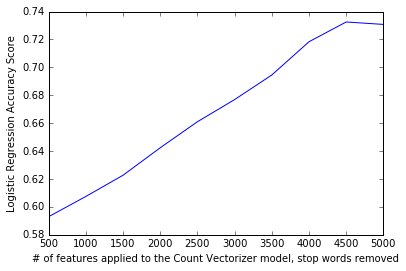

In [22]:
import matplotlib.pyplot as plt
plt.plot(max_feat, accuracy_scores)
plt.xlabel('# of features applied to the Count Vectorizer model, stop words removed')
plt.ylabel('Logistic Regression Accuracy Score')


## Using Bill Text to predict passage

In [23]:
X= data.bill_text_nonumbers
y= data.PLaw

# The PLaw variable is coded as 0 for not passed to public law and 1 for passed.

In [24]:
max_feat = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
accuracy_scores=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

for num in max_feat:
    vect= TfidfVectorizer(stop_words='english', max_features=num)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    logreg = LogisticRegression()
    logreg.fit(X_train_dtm, y_train)
    y_pred_class = logreg.predict(X_test_dtm)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred_class))
    

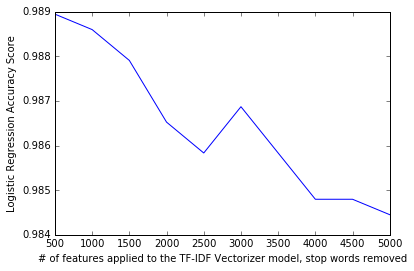

In [25]:
import matplotlib.pyplot as plt
plt.plot(max_feat, accuracy_scores)
plt.xlabel('# of features applied to the TF-IDF Vectorizer model, stop words removed')
plt.ylabel('Logistic Regression Accuracy Score')

In [26]:
# count vectorizer, with and without stop words
print "***Count Vectorizer, with stop words***"
vect= CountVectorizer(max_features=500)
analyze(vect, X, y)

print "\n" + "***Count Vectorizer, stop words removed***"
vect= CountVectorizer(max_features=500, stop_words='english')
analyze(vect, X, y)

***Count Vectorizer, with stop words***
Features:  500
Naive Bayes Accuracy:  0.951278507256
Logistic Regression Accuracy:  0.99792674499

***Count Vectorizer, stop words removed***
Features:  500
Naive Bayes Accuracy:  0.957843814789
Logistic Regression Accuracy:  0.998963372495


In [18]:
# TD-IDF vectorizer
vect= TfidfVectorizer(max_features=500)
print "***TF-IDF Vectorizer, with stop words***"
analyze(vect, X, y)

vect= TfidfVectorizer(max_features=500, stop_words='english')
print "\n" + "***TF-IDF Vectorizer, stop words removed***"
analyze(vect, X, y)

***TF-IDF Vectorizer, with stop words***
Features:  500
Naive Bayes Accuracy:  0.942294402211
Logistic Regression Accuracy:  0.974775397374

***TF-IDF Vectorizer, stop words removed***
Features:  500
Naive Bayes Accuracy:  0.965100207326
Logistic Regression Accuracy:  0.988942639945


In [ ]:
vect.get_feature_names()

In [27]:
# with bigrams 
vect = CountVectorizer(ngram_range=(1, 2), max_features=500, stop_words='english')
print "***Count Vectorizer, including bigrams, stop words removed***"
analyze(vect, X, y)

***Count Vectorizer, including bigrams, stop words removed***
Features:  500
Naive Bayes Accuracy:  0.981340704907
Logistic Regression Accuracy:  0.998963372495


# Bill summarization

In [19]:
X= data.bill_text_nonumbers
y= data.PLaw

vect = TfidfVectorizer(stop_words='english', max_features=5000)

dtm = vect.fit_transform(X)
features = vect.get_feature_names()
dtm.shape

(11573, 5000)

In [20]:
def summarize(data):

    bill_index = np.random.randint(0, len(data))        
    bill_text = unicode(data.bill_text_clean[bill_index], 'utf-8')
    bill_length = len(bill_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(bill_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[bill_index, features.index(word)]
   
    #print title
    print 'TITLE'
    print data.Title[bill_index]
    
   
        
    #print if R or D
    print '\n' + 'BY'
    print data.NameFirst[bill_index] + ' ' + data.NameLast[bill_index]+', ' + data.PartyName[bill_index]
    
    # print if passed or not
    print '\n' + 'PASSED?'
    if data.PLaw[bill_index]==1:
        print 'Yes'
    else:
        print 'No'
    
    # print words with the top 5 TF-IDF scores
    print '\n' + 'TOP SCORING WORDS:'
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print word
    
    # print 5 random words
    print '\n' + 'RANDOM WORDS:'
    random_words = np.random.choice(word_scores.keys(), size=5, replace=False)
    for word in random_words:
        print word
    
    # print the review
    print '\n' + bill_text

In [23]:
summarize(data)

TITLE
A bill to amend title XVIII of the Social Security Act to accelerate the reduction in the amount of beneficiary copayment liability for medicare outpatient services.

BY
Kent Conrad, D

PASSED?
No

TOP SCORING WORDS:
performed
outpatient
procedures
medicare
percent

RANDOM WORDS:
hospital
sec
states
prospective
medicare

[Congressional Bills 108th Congress]
[From the U.S. Government Printing Office]
[S. 1017 Introduced in Senate (IS)]






108th CONGRESS
  1st Session
                                S. 1017

   To amend title XVIII of the Social Security Act to accelerate the 
reduction in the amount of beneficiary copayment liability for medicare 
                          outpatient services.


_______________________________________________________________________


                   IN THE SENATE OF THE UNITED STATES

                              May 7, 2003

 Mr. Conrad (for himself, Mr. Bingaman, Mr. Levin, Ms. Landrieu, and 
        Mr. Johnson) introduced the following

# Sentiment Analyses

Where do bills rank in sentiment analysis?
Is there a difference in Sentiment between R and D bills?

Subjectivity and sentiment


In [31]:
# polarity ranges from -1 (most negative) to 1 (most positive)
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity


data['Sentiment'] = data.bill_text_clean.apply(detect_sentiment)

In [16]:
# polarity ranges from 0 (most objective) to 1 (most subjective)

def detect_subjectivity(text):
    return TextBlob(text.decode('utf-8')).sentiment.subjectivity

data['Subjectivity'] = data.bill_text_clean.apply(detect_subjectivity)

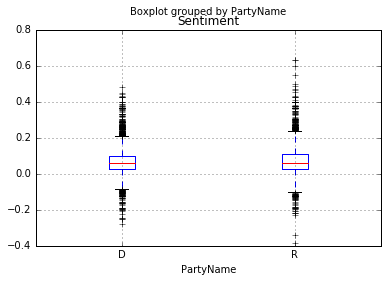

In [32]:
data.boxplot(column='Sentiment', by='PartyName')


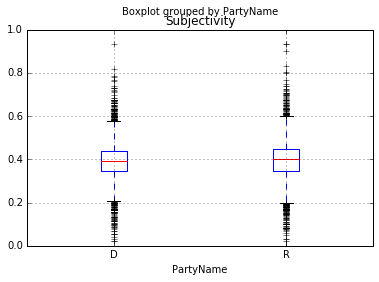

In [17]:
data.boxplot(column='Subjectivity', by='PartyName')

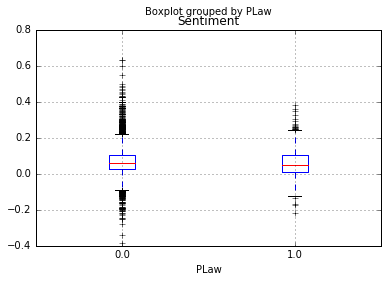

In [33]:
data.boxplot(column='Sentiment', by='PLaw')

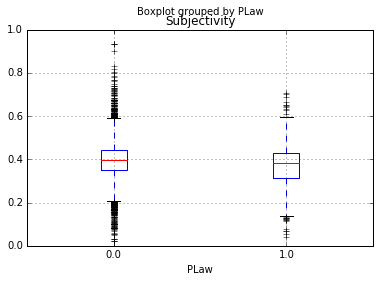

In [18]:
data.boxplot(column='Subjectivity', by='PLaw')